# KIT-Loe-GE Cell Segmentation and Tracking


Simultaneous cell segmentation and tracking method used for our submission as team KIT-Loe-GE to the [Cell Tracking Challenge](http://celltrackingchallenge.net/) in 2022.

The code is publicly available at https://github.com/kaloeffler/EmbedTrack.

----

Publication:
K. Löffler and M. Mikut (2022). EmbedTrack -- Simultaneous Cell Segmentation and Tracking Through Learning Offsets and Clustering Bandwidths. arXiv preprint. DOI: [10.48550/arXiv.2204.10713](https://doi.org/10.48550/arXiv.2204.10713)

----


## 1) Setting up the environment

Creating the environment, cloning the code and adding some utilities for downloading the CTC data. Everything (data, code, trained models) will be stored in a folder named "EmbedTrack", so you can access it later.

In [1]:
!git clone https://github.com/kaloeffler/EmbedTrack.git

Cloning into 'EmbedTrack'...
remote: Enumerating objects: 129, done.
remote: Counting objects: 100% (129/129), done.
remote: Compressing objects: 100% (77/77), done.
remote: Total 129 (delta 56), reused 119 (delta 50), pack-reused 0
Receiving objects: 100% (129/129), 3.66 MiB | 5.06 MiB/s, done.
Resolving deltas: 100% (56/56), done.


In [9]:
!pip install imagecodecs --no-dependencies
!pip install cffi=="1.16.0"
!pip install albumentations

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.6/123.6 kB 982.6 kB/s eta 0:00:0000:0100:01
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/f1/6c/49f5a0ce8ddcdbdac5ac69c129654938cc6de0a936303caa6cad495ceb2a/scikit_image-0.22.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (14.7 MB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 9.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.2/62.2 MB 3.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 3.4 MB/s eta 0:00:0000:0100:01
  Using cached https://pypi.tuna.tsinghua.edu.cn/packages/a1/c3/65b3814e155836acacf720e5be3b5757130346670ac454fee29d3eda1381/lazy_loader-0.3-py3-none-any.whl (9.1 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.4/313.4 kB 802.8 kB/s eta 0

**Check cuda is available - otherwise set in colab under "runtime" -> "change runtime type" the runtime from "None" to "GPU"**



In [2]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)

/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True
1.13.1


**Utilities to facilitate downloading data from the Cell Tracking Challenge**

Please note: you need to run this cell before jumping to the training / inference sections!

In [3]:
import requests
import zipfile
import os

def retrieve_ctc_data(url, save_dir):
  zip_file = os.path.join(save_dir, url.split("/")[-1])
  with requests.get(url, stream=True) as req:
    req.raise_for_status()
    with open(zip_file, "wb") as file:
      for chunk in req.iter_content(chunk_size=8192):
        file.write(chunk)
  print(f"Unzip data set {os.path.basename(zip_file)}")
  with zipfile.ZipFile(zip_file) as z:
    z.extractall(save_dir)

  os.remove(zip_file)


## 2.) Training and Inference

### 2.1.) Select a data set to do training / inference on

EmbedTrack was tested and trained on the following 2D datasets, as they all provide an additional Silver Truth (ST) which will be processed together with the Gold Truth annotations (GT) to get fully labelled cell segmentation masks with resonable annotation quality:
"Fluo-N2DH-SIM+",
  "Fluo-C2DL-MSC",
    "Fluo-N2DH-GOWT1",
    "PhC-C2DL-PSC",
    "BF-C2DL-HSC",
    "Fluo-N2DL-HeLa",
    "BF-C2DL-MuSC",
    "DIC-C2DH-HeLa", and
    "PhC-C2DH-U373".

In [1]:
# possible data sets:

#[    "Fluo-N2DH-SIM+",
#    "Fluo-C2DL-MSC",
#    "Fluo-N2DH-GOWT1",
#    "Fluo-N2DL-HeLa",
#]

data_set = "Fluo-N2DH-SIM+"


### 2.2.) Download the selected data set from the Cell Tracking Challenge

In [2]:
# change to the embedtrack folder that has been created in your drive
%cd EmbedTrack/
!ls

/home/user2/project/CellTrackingProject/EmbedTrack
ctc_raw_data  environment.yml  kit_loe_ge.ipynb  README.md
data	      gifs	       LICENSE		 results
embedtrack    __init__.py      models


/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [6]:
import os
from pathlib import Path

ctc_data_url = "http://data.celltrackingchallenge.net"
ctc_metrics_url = "http://public.celltrackingchallenge.net/software/EvaluationSoftware.zip"

training_data_url = os.path.join(ctc_data_url, "training-datasets/")
challenge_data_url = os.path.join(ctc_data_url, "test-datasets/")

current_path = Path.cwd()
data_path = current_path / 'ctc_raw_data'
ctc_metrics_path = os.path.join(current_path, "embedtrack", "ctc_metrics", "CTC_eval")

# Download training data set
if not os.path.exists(data_path / "train" / data_set):
  dp = os.path.join(data_path, "train", data_set)
  print(f"Downloading training data set to {dp} ...")
  data_url = training_data_url + data_set + ".zip"
  retrieve_ctc_data(data_url, os.path.join(data_path, "train"))

# Download challenge data set
if not os.path.exists(data_path / "challenge" / data_set):
  dp = os.path.join(data_path, "challenge", data_set)
  print(f"Downloading challenge data set to {dp} ...")
  data_url = challenge_data_url + data_set + ".zip"
  retrieve_ctc_data(data_url, os.path.join(data_path, "challenge"))

# Download evaluation software
if len(os.listdir(ctc_metrics_path)) <= 1:
  print(f"Downloading  ctc metrics to {ctc_metrics_path} ...")
  retrieve_ctc_data(ctc_metrics_url, ctc_metrics_path)

# make CTC metrics executable
!chmod -R 755 $ctc_metrics_path

Unzip data set Fluo-N2DH-SIM+.zip
Unzip data set Fluo-N2DH-SIM+.zip
Unzip data set EvaluationSoftware.zip


num_images: 65


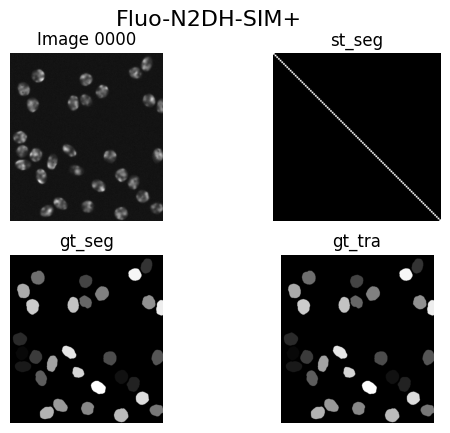

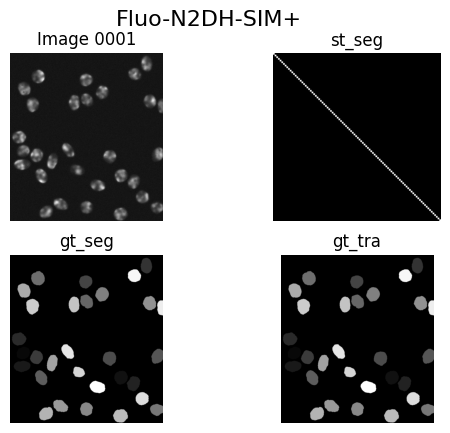

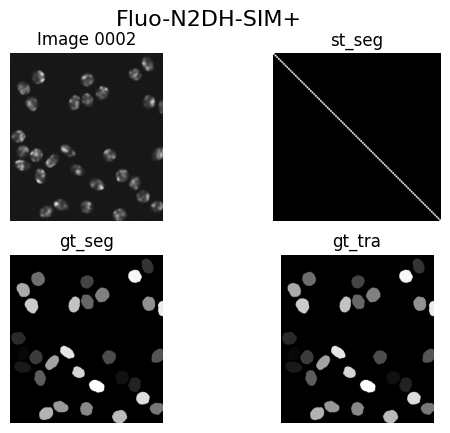

<Figure size 640x480 with 0 Axes>

In [7]:
# inspect data
import tifffile
import glob
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

path_dataset = Path(f'ctc_raw_data/train/{data_set}')
subset_select = '01'
path_sample = path_dataset/f'{subset_select}'
path_gt_seg = path_dataset/f'{subset_select}_GT/SEG'
path_gt_tra = path_dataset/f'{subset_select}_GT/TRA'
path_st_seg = path_dataset/f'{subset_select}_ST/SEG'

num_images = len(list(path_sample.glob('*.tif')))
print(f'num_images: {num_images}')

# read if exists, else return an empty image
def read_image(path):
    image_path = path
    if image_path.exists():
        image = tifffile.imread(image_path)
    else:
        image = np.eye(100) * 255
    return image


# use matplotlib to plot it, only show first 3 samples
for i in range(0, 3):
    image = read_image(path_sample/f't{i:03d}.tif')
    gt_seg = read_image(path_gt_seg/f'man_seg{i:03d}.tif')
    gt_tra = read_image(path_gt_tra/f'man_track{i:03d}.tif')
    st = read_image(path_st_seg/f'man_seg{i:03d}.tif')


    plt.subplot(221)
    # Add prompt
    plt.text(1.3, 1.2, f'{path_dataset.name}', ha='center', va='center', transform=plt.gca().transAxes, fontsize=16)

    plt.imshow(image, cmap='gray')
    plt.title(f'Image {i:04d}')
    plt.axis('off')
    plt.subplot(222)
    plt.imshow(st, cmap='gray')
    plt.title('st_seg')
    plt.axis('off')
    plt.subplot(223)
    plt.imshow(gt_seg, cmap='gray')
    plt.title('gt_seg')
    plt.axis('off')
    plt.subplot(224)
    plt.imshow(gt_tra, cmap='gray')
    plt.title('gt_tra')
    plt.axis('off')


    # plt.show()
    plt.pause(0.5)
    plt.clf()

# plt.close('all')

### 2.3.) Train a model for the selected data set

In [3]:
# remove preprocessed data if necessary
!rm -rf data/

In [4]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
np.int = int
np.object = object
np.bool = bool

import collections
collections.Iterable = collections.abc.Iterable

import os
os.environ['CUDA_VISIBLE_DEVICES']='0,1'

matplotlib.use("Agg")
from embedtrack.train.run_training_pipeline import (
    DataConfig,
    ModelConfig,
    TrainConfig,
    run_pipeline,
)
import os
from pathlib import Path

# data configs

PROJECT_PATH = Path.cwd()

RAW_DATA_PATH = os.path.join(PROJECT_PATH, "ctc_raw_data/train")
DATA_PATH_DEST = os.path.join(PROJECT_PATH, "data")
MODEL_PATH = os.path.join(PROJECT_PATH, "models")

USE_SILVER_TRUTH = True
TRAIN_VAL_SEQUNCES = ["01", "02"]
TRAIN_VAL_SPLIT = 0.1

N_EPOCHS = 15
# Adam optimizer; normalize images; OneCycle LR sheduler; N epochs
MODEL_NAME = "adam_norm_onecycle_" + str(N_EPOCHS)

if data_set == "Fluo-N2DH-SIM+":
    use_silver_truth = False
else:
    use_silver_truth = USE_SILVER_TRUTH

data_config = DataConfig(
    RAW_DATA_PATH,
    data_set,
    DATA_PATH_DEST,
    use_silver_truth=use_silver_truth,
    train_val_sequences=TRAIN_VAL_SEQUNCES,
    train_val_split=TRAIN_VAL_SPLIT,
)

# train configs
MODEL_SAVE_DIR = os.path.join(
    MODEL_PATH,
    data_set,
    MODEL_NAME,
)
if data_set != "Fluo-C2DL-MSC":
    CROP_SIZE = 256
    TRAIN_BATCH_SIZE = 16
    VAL_BATCH_SIZE = 16
    DISPLAY_IT = 1000

else:
    CROP_SIZE = 512
    TRAIN_BATCH_SIZE = 8
    VAL_BATCH_SIZE = 8
    DISPLAY_IT = 200

CENTER = "medoid"
RESUME_TRAINING = False
TRAIN_SIZE = None  # if None training on full train data set; otherwise still training on full data set but only use a fraction of the data per epoch
VAL_SIZE = None  # if None validation on full val data set; otherwise still val on full data set but only use a fraction of the data per epoch
VIRTUAL_TRAIN_BATCH_MULTIPLIER = 1
VIRTUAL_VAL_BATCH_MULTIPLIER = 1
DISPLAY = False

train_config = TrainConfig(
    MODEL_SAVE_DIR,
    crop_size=CROP_SIZE,
    center=CENTER,
    resume_training=RESUME_TRAINING,
    train_size=TRAIN_SIZE,
    train_batch_size=TRAIN_BATCH_SIZE,
    virtual_train_batch_multiplier=VIRTUAL_TRAIN_BATCH_MULTIPLIER,
    val_size=VAL_SIZE,
    val_batch_size=VAL_BATCH_SIZE,
    virtual_val_batch_multiplier=VIRTUAL_VAL_BATCH_MULTIPLIER,
    n_epochs=N_EPOCHS,
    display=DISPLAY,
    display_it=DISPLAY_IT,
)

# model config
INPUT_CHANNELS = 1
N_SEG_CLASSES = [4, 1]
N_TRACK_CLASSES = 2

model_config = ModelConfig(INPUT_CHANNELS, N_SEG_CLASSES, N_TRACK_CLASSES)

run_pipeline(data_config, train_config, model_config)
plt.close("all")


/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


prepare data of Fluo-N2DH-SIM+
data stored in /home/user2/project/CellTrackingProject/EmbedTrack/data
Dataset properies of the `Fluo-N2DH-SIM+` dataset is saved to /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/data_properties.json
/home/user2/project/CellTrackingProject/EmbedTrack/data/crops


  0%|                                                                                                                                                                                     | 0/59 [00:00<?, ?it/s]

Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/01/images/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/01/masks/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/01/center-medoid/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/train/01/center-medoid/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [01:05<00:00,  1.11s/it]


Cropping of images, instances and centre_images for data_subset = `train/01` done!


  0%|                                                                                                                                                                                    | 0/135 [00:00<?, ?it/s]

Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/02/images/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/02/masks/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/02/center-medoid/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/train/02/center-medoid/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [01:22<00:00,  1.64it/s]


Cropping of images, instances and centre_images for data_subset = `train/02` done!


  0%|                                                                                                                                                                                      | 0/6 [00:00<?, ?it/s]

Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/01/images/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/01/masks/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/01/center-medoid/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/val/01/center-medoid/


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [00:06<00:00,  1.02s/it]


Cropping of images, instances and centre_images for data_subset = `val/01` done!


  0%|                                                                                                                                                                                     | 0/15 [00:00<?, ?it/s]

Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/02/images/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/02/masks/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/02/center-medoid/
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/val/02/center-medoid/


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:16<00:00,  1.07s/it]


Cropping of images, instances and centre_images for data_subset = `val/02` done!
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/01/center-medoid-flow
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/train/01/center-medoid-flow
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/train/02/center-medoid-flow
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/train/02/center-medoid-flow
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/01/center-medoid-flow
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/Fluo-N2DH-SIM+/val/01/center-medoid-flow
Created new directory : /home/user2/project/CellTrackingProject/EmbedTrack/data/crops/Fluo-N2DH-SIM+/val/02/center-medoid-flow
Created new directory : /home/user2/proj

  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:18<00:00,  2.77it/s]


===> train loss: 5.008720
===> val loss: 4.7997, val iou: 0.0000
=> saving checkpoint
Starting epoch 1
learning rate: 7.620174031281384e-05


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:18<00:00,  2.77it/s]


===> train loss: 2.131178
===> val loss: 3.8663, val iou: 0.0000
=> saving checkpoint
Starting epoch 2
learning rate: 0.00021848499779968073


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:18<00:00,  2.82it/s]


===> train loss: 1.737691
===> val loss: 3.4539, val iou: 0.0000
=> saving checkpoint
Starting epoch 3
learning rate: 0.0003802117167261162


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:19<00:00,  2.65it/s]


===> train loss: 1.578439
===> val loss: 3.5399, val iou: 0.0000
=> saving checkpoint
Starting epoch 4
learning rate: 0.0004856375382692291


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [01:00<00:00,  1.17s/it]


===> train loss: 1.472161
===> val loss: 3.4081, val iou: 0.5996
=> saving checkpoint
Starting epoch 5
learning rate: 0.0004971832702368266


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:40<00:00,  1.27it/s]


===> train loss: 1.414681
===> val loss: 3.2006, val iou: 0.6454
=> saving checkpoint
Starting epoch 6
learning rate: 0.0004751712517692197


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:43<00:00,  1.19it/s]


===> train loss: 1.352230
===> val loss: 3.2750, val iou: 0.6423
=> saving checkpoint
Starting epoch 7
learning rate: 0.0004331518682885435


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:39<00:00,  1.32it/s]


===> train loss: 1.301684
===> val loss: 3.0905, val iou: 0.6513
=> saving checkpoint
Starting epoch 8
learning rate: 0.0003748587264160831


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:35<00:00,  1.45it/s]


===> train loss: 1.259159
===> val loss: 3.1745, val iou: 0.6563
=> saving checkpoint
Starting epoch 9
learning rate: 0.00030547142762244627


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:38<00:00,  1.34it/s]


===> train loss: 1.217972
===> val loss: 3.1788, val iou: 0.6637
=> saving checkpoint
Starting epoch 10
learning rate: 0.00023115533790659298


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:37<00:00,  1.37it/s]


===> train loss: 1.158526
===> val loss: 3.2377, val iou: 0.6602
=> saving checkpoint
Starting epoch 11
learning rate: 0.00015851376797056474


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:35<00:00,  1.45it/s]


===> train loss: 1.127316
===> val loss: 3.2010, val iou: 0.6756
=> saving checkpoint
Starting epoch 12
learning rate: 9.400124008545676e-05


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:35<00:00,  1.45it/s]


===> train loss: 1.091997
===> val loss: 3.0900, val iou: 0.6618
=> saving checkpoint
Starting epoch 13
learning rate: 4.3349975462426465e-05


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:36<00:00,  1.43it/s]


===> train loss: 1.069170
===> val loss: 3.0140, val iou: 0.6613
=> saving checkpoint
Starting epoch 14
learning rate: 1.10605612426437e-05


  0%|                                                                                                                                                                                    | 0/457 [00:00<?, ?it/s]/home/user2/miniconda3/envs/pytorch113_cu117/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 52/52 [00:36<00:00,  1.41it/s]


===> train loss: 1.056498
===> val loss: 3.1532, val iou: 0.6658
=> saving checkpoint


### 2.4.) Inference using the just trained model

In [5]:
# make CTC metrics executable
current_path = Path.cwd()
ctc_metrics_path = os.path.join(current_path, "embedtrack", "ctc_metrics", "CTC_eval")
!chmod -R 755 $ctc_metrics_path

In [6]:
import os
from datetime import datetime
from pathlib import Path
from time import time
import shutil
from embedtrack.ctc_metrics.eval_ctc import calc_ctc_scores
from embedtrack.infer.infer_ctc_data import inference

PROJECT_PATH = Path.cwd()

RAW_DATA_PATHS = [os.path.join(PROJECT_PATH, "ctc_raw_data/challenge"),
                  os.path.join(PROJECT_PATH, "ctc_raw_data/train")]
MODEL_PATH = os.path.join(PROJECT_PATH, "models")
RES_PATH = os.path.join(PROJECT_PATH, "results")

# Adam optimizer; normalize images; OneCycle LR sheduler; N epochs
MODEL_NAME = "adam_norm_onecycle_15"
BATCH_SIZE = 32

for raw_data_path in RAW_DATA_PATHS:
      for data_id in ["01", "02"]:
          img_path = os.path.join(raw_data_path, data_set, data_id)

          model_dir = os.path.join(MODEL_PATH, data_set, MODEL_NAME)
          if not os.path.exists(model_dir):
              print(f"no trained model for data set {data_set}")
              continue

          # time stamps
          timestamps_trained_models = [
              datetime.strptime(time_stamp, "%Y-%m-%d---%H-%M-%S")
              for time_stamp in os.listdir(model_dir)
          ]
          timestamps_trained_models.sort()
          last_model = timestamps_trained_models[-1].strftime("%Y-%m-%d---%H-%M-%S")
          model_path = os.path.join(model_dir, last_model, "best_iou_model.pth")
          config_file = os.path.join(model_dir, last_model, "config.json")
          t_start = time()
          inference(img_path, model_path, config_file, batch_size=BATCH_SIZE)
          t_end = time()

          run_time = t_end - t_start
          print(f"Image sequence: {img_path}")
          print(f"Inference Time {img_path}: {run_time}s")

          res_path = os.path.join(RES_PATH, data_set, MODEL_NAME, last_model, os.path.basename(raw_data_path), data_id+"_RES")
          if not os.path.exists(os.path.dirname(res_path)):
            os.makedirs(os.path.dirname(res_path))
          shutil.move(img_path+"_RES", res_path)
          if os.path.basename(raw_data_path) == "train":
            metrics = calc_ctc_scores(Path(res_path), Path(img_path+"_GT"))
            print(metrics)



`model_dict` dictionary successfully created with: 
 -- num of classes equal to [4, 1, 2], 
 -- input channels equal to 1, 
 -- name equal to 2d
Creating branched erfnet with [4, 1, 2] classes
Save tracking mask t109.tif
Save tracking mask t108.tif
Save tracking mask t107.tif
Save tracking mask t106.tif
Save tracking mask t105.tif
Save tracking mask t104.tif
Save tracking mask t103.tif
Save tracking mask t102.tif
Save tracking mask t101.tif
Save tracking mask t100.tif
Save tracking mask t099.tif
Save tracking mask t098.tif
Save tracking mask t097.tif
Save tracking mask t096.tif
Save tracking mask t095.tif
Save tracking mask t094.tif
Save tracking mask t093.tif
Save tracking mask t092.tif
Save tracking mask t091.tif
Save tracking mask t090.tif
Save tracking mask t089.tif
Save tracking mask t088.tif
Save tracking mask t087.tif
Save tracking mask t086.tif
Save tracking mask t085.tif
Save tracking mask t084.tif
Save tracking mask t083.tif
Save tracking mask t082.tif
Save tracking mask t081

## 3.) Visualization

Calculate metrics as well as visualization.

In [9]:
# process res_track.txt
import pandas as pd
from pathlib import Path

lineage_file = Path(res_path) / "res_track.txt"
lineage = pd.read_csv(
    lineage_file,
    delimiter=" ",
    header=None,
    names=["cell_id", "t_start", "t_end", "predecessor"],
)
lineage

,cell_id,t_start,t_end,predecessor
0,1,104,149,93
1,2,94,149,99
2,3,149,149,54
3,4,139,149,77
4,5,104,149,92
...,...,...,...,...
117,118,0,28,0
118,119,0,27,0
119,120,0,24,0
120,121,0,23,0


In [25]:
from pathlib import Path
import re
import subprocess
import numpy as np
from tqdm import tqdm
import tifffile
import matplotlib.pyplot as plt
from datetime import datetime
import cv2

class CellRes:
    '''This class reads in the dataset of cell tracking challenge,
    And then do some visualization.

    Args:
        root_folder (str): The root folder of the dataset.
        dataset_select (int): The index of the dataset to be selected. [0, 8]


    Usage:
        cellres = CellRes(0, exp='xxx')
        cellres.make_video()
        cellres.evaluate_metrics()
    '''
    PALETTE = {0: np.array([0, 0, 0]),} # black

    def __init__(self, dataset_select, exp='KIT-Loe-GE', res_path='./results/',
                  data_path='./data/', load=True):
        self.dataset = dataset_select
        self.exp = exp

        self.res_path = res_path
        self.data_path = data_path

        # key (str): img sequence {'01', '02'}; value (List[str]): img path
        self.keys = ['01', '02']
        self.image = {}
        self.pred = {}
        self.target = {}

        self.image_challenge = {}
        self.pred_challenge = {}

        self.color_range = None # (min, max)

        # Read in the data
        if load:
            self._load()

    def _load(self, include_val=True):
        '''Method to load all data. Can be called manually'''
        self.get_train_img_list(path=self.data_path, include_val=include_val)
        self.get_challenge_img_list(path='./ctc_raw_data/')
        self.get_pred_list(path=self.res_path)

    def get_train_img_list(self, path, include_val):
        ''' Read the train folder. (path='./data')
        Read in all the images to put into self.image,and all gt masks to put into self.target.
        '''
        path = Path(path) / self.dataset
        keys = [i.name for i in (path/'train').iterdir()]
        self.keys = keys

        for key in keys:
            img_list = list((path/'train'/key/'images').glob('*.tif'))
            mask_list = list((path/'train'/key/'masks').glob('*.tif'))
            if include_val:
                img_list.extend(list((path/'val'/key/'images').glob('*.tif')))
                mask_list.extend(list((path/'val'/key/'masks').glob('*.tif')))
            img_list.sort()
            mask_list.sort()

            for img, mask in zip(img_list, mask_list):
                assert img.name == mask.name, f'Name not match: {img.name} != {mask.name}'\

            self.image[key] = img_list
            self.target[key] = mask_list

    def get_challenge_img_list(self, path):
        ''' Read the raw challenge folder. (path='./ctc_raw_data/')'''
        path = Path(path) / 'challenge' / self.dataset
        keys = [i.name for i in path.iterdir()]
        self.keys = keys

        for key in keys:
            img_list = list((path/key).glob('*.tif'))
            img_list.sort()

            self.image_challenge[key] = img_list

    def get_pred_list(self, path):
        ''' Read the pred results for train and challenge. (path='./results')'''
        path = Path(path) / self.dataset / self.exp
        if self.keys is None:
            raise ValueError('Please run get_train_img_list() or get_challenge_img_list() first.')
        keys = self.keys

        for key in keys:
            pred_list = sorted(list((path/'train'/(key+'_RES')).glob('*.tif')))
            self.pred[key] = pred_list

            pred_challenge_list = sorted(list((path/'challenge'/(key+'_RES')).glob('*.tif')))
            self.pred_challenge[key] = pred_challenge_list


    # ------------------ Process the data ------------------
    def check_availability(self, verbose=False):
        '''Check if dataset and pred are available'''
        res_path = self.res_path
        try:
            dataset_folder = Path(res_path)/self.dataset/self.exp
            assert dataset_folder.parent.exists(), f'{dataset_folder.parent} does not exist.'
            assert dataset_folder.exists(), f'{dataset_folder} does not exist.'
            res_train = dataset_folder/'train'
            assert res_train.exists and len(list(res_train.iterdir())) == 2,\
                f'{res_train} does not have 2 folders.'
            # res_challenge = dataset_folder/'challenge'
            # assert res_challenge.exists and len(list(res_challenge.iterdir())) == 2,\
            #     f'{res_challenge} does not have 2 folders.'
        except AssertionError as e:
            if verbose: print(e)
            return False
        except FileNotFoundError as e:
            if verbose: print(e)
            return False
        else:
            return True

    def load_image(self, path, scale=True, rgb=False):
        path = str(path)
        img = tifffile.imread(path)
        if scale and self.color_range is not None:
            img = img.astype(np.float32)
            img = (img - self.color_range[0]) / (self.color_range[1] - self.color_range[0])
        if rgb:
            img = np.stack([img, img, img], axis=-1)
        return img

    def preprocess_img_list(self, choice=1, color_range=None):
        '''Preprocess the images, get the min and max, to better convert them into float32 dtype'''
        if color_range is not None:
            self.color_range = color_range
            return

        for key in self.keys:
            img_list = self.image[key] + self.image_challenge[key]
            if choice < 1:
                img_list = np.random.choice(img_list, size=int(len(img_list)*choice), replace=False)
            for img_path in tqdm(img_list, desc=f'Preprocess {key}'):
                img = tifffile.imread(img_path)
                if self.color_range is None:
                    self.color_range = (img.min(), img.max())
                else:
                    self.color_range = (
                        min(self.color_range[0], img.min()),
                        max(self.color_range[1], img.max())
                    )
        print(f'color_range: {self.color_range}')


    def merge_image(self, img, mask, alpha=0.5):
        '''merge the image and the mask with alpha blending'''
        img = img.astype(np.float32)
        mask = mask.astype(np.float32)
        # img = img / img.max()
        # mask = mask / mask.max()
        img = np.where(mask>0, img*(1-alpha)+mask*alpha, img)
        return img

    def seg2rgb(self, seg):
        '''convert the segmentation to rgb image'''
        rgb = np.zeros((*seg.shape, 3), dtype=np.float32)
        for idx in np.unique(seg):
            rgb[seg==idx] = self.palette(idx)
        return rgb

    # ------------------ Eval Metrics -------------------

    def evaluate_metrics(self, res_path=None, gt_path='./ctc_raw_data/'):
        tmp_path = Path('./temp/')
        res_path = res_path or self.res_path
        if not tmp_path.exists():
            tmp_path.mkdir()
        ctc_metric_path = Path('./embedtrack/ctc_metrics/CTC_eval/Linux')
        ctc_measures = [i.name for i in ctc_metric_path.iterdir() if 'Measure' in i.name]
        metrics = {}

        for k in self.keys:
            result_dir = Path(res_path) / self.dataset / self.exp / 'train' \
                / (k+'_RES')
            gt_dir = Path(gt_path) / 'train' / self.dataset / (k+'_GT')
            num_images = len(list(result_dir.glob('*.tif')))
            n_digits = 3 if num_images < 1000 else 4

            tmp_res = tmp_path / (k+'_RES')
            tmp_gt = tmp_path / (k+'_GT')
            if tmp_res.exists():
                tmp_res.unlink()
            if tmp_gt.exists():
                tmp_gt.unlink()

            tmp_res.symlink_to(result_dir.absolute())
            tmp_gt.symlink_to(gt_dir.absolute())

            metrics[k] = {}
            for measure_f in ctc_measures:
                if not (tmp_res / 'res_track.txt').exists() and measure_f.startswith('TRA'):
                    continue
                output = subprocess.Popen(
                    [
                        (ctc_metric_path/measure_f).as_posix(),
                        tmp_path.as_posix(),
                        k,
                        str(n_digits),
                    ],
                    stdout=subprocess.PIPE,
                    stderr=subprocess.PIPE,
                )
                stdout, stderr = output.communicate()
                if stderr:
                    print(stderr.decode('utf-8'))

                # print(stdout.decode('utf-8'))
                metric_score = re.findall(r"\d\.\d*", stdout.decode("utf-8"))

                assert len(metric_score) == 1, f'len(metric_score) != 1, {metric_score}'
                metrics[k][measure_f[:3]] = metric_score[0]

        return metrics


    # ------------------ Visualization ------------------

    def get_pic(self, idx, _type, key='01', select='train'):
        '''
        get single image of any type.
        Args:
            idx (int): index of the image
            _type (str): 'img', 'target', 'pred'
            key (str): '01', '02'
            select (str): 'train', 'challenge'
        '''
        if select=='train':
            ds_image = self.image
            ds_pred = self.pred
            ds_target = self.target
        elif select=='challenge':
            ds_image = self.image_challenge
            ds_pred = self.pred_challenge
            ds_target = None
        else:
            raise NotImplementedError(f'select={select} is not supported.')

        img = self.load_image(ds_image[key][idx], rgb=True, scale=True)
        if _type == 'img':
            img_res = img
        elif _type == 'target':
            target = self.load_image(ds_target[key][idx], scale=False)
            target = self.seg2rgb(target)
            img_res = self.merge_image(img, target)
        elif _type == 'pred':
            pred = self.load_image(ds_pred[key][idx], scale=False)
            pred = self.seg2rgb(pred)
            img_res = self.merge_image(img, pred)

        return img_res

    def get_single_frame(self, idx, key='01', select='train', with_gt=False):
        '''get single image, [img+target | img+pred]'''

        img_1 = self.get_pic(idx, 'target' if with_gt else 'img', key=key, select=select)
        img_2 = self.get_pic(idx, 'pred', key=key, select=select)
        res = np.concatenate([img_1, img_2], axis=1)
        # plt.imshow(img)
        # plt.show()
        return res

    def make_video(self, path='./visualization/', fps=5, select='train'):
        '''make a video from the images and save it to the path.
        video is structed as [img+target | img+pred]
        '''
        if self.color_range is None:
            self.preprocess_img_list(choice=1)

        for key in self.keys:
            img = self.get_single_frame(0, key, select=select)
            height, width, _ = img.shape

            vid_name = f'{self.dataset}_{select}_{key}_{self.exp}_'\
                       f'{datetime.now().strftime("%m%d-%H%M")}.mp4'
            fourcc = cv2.VideoWriter_fourcc(*'mp4v') # MJPG
            os.makedirs(os.path.dirname(path+vid_name), exist_ok=True)
            videoWriter = cv2.VideoWriter(path+vid_name, fourcc, fps, (width, height))

            print(f'Video will be saved to {path+vid_name}')
            img_list = self.image[key] if select=='train' else self.image_challenge[key]
            for i in tqdm(range(len(img_list)), desc='Making video'):
                img = self.get_single_frame(i, key, select=select)
                img = (img * 255).astype(np.uint8)
                videoWriter.write(img)

        pass

    def palette(self, idx):
        '''given the image, return the palette rgb color'''
        if idx not in self.PALETTE:
            self.PALETTE[idx] = np.random.uniform(0.5, 1, size=(3,)).astype(np.float32)
        return self.PALETTE[idx]

In [26]:
# load data
res = CellRes('Fluo-N2DH-SIM+', exp=f'adam_norm_onecycle_15/{last_model}', load=False)
res.check_availability(verbose=True)
res._load(include_val=False)

In [27]:
# Visualize train set and calculate metrics
res.make_video(select='train')
res.evaluate_metrics()

Preprocess 02: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 273/273 [00:02<00:00, 93.28it/s]


color_range: (70, 788)
Video will be saved to ./visualization/Fluo-N2DH-SIM+_train_01_adam_norm_onecycle_15/2024-03-04---12-24-43_0304-1415.mp4


Making video: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 59/59 [00:05<00:00, 10.63it/s]


Video will be saved to ./visualization/Fluo-N2DH-SIM+_train_02_adam_norm_onecycle_15/2024-03-04---12-24-43_0304-1415.mp4


Making video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 135/135 [00:13<00:00, 10.19it/s]


{'01': {'SEG': '0.889412', 'TRA': '0.983643', 'DET': '0.983928'},
 '02': {'SEG': '0.780475', 'TRA': '0.960236', 'DET': '0.964729'}}

In [28]:
# Visualize challenge set
res.make_video(select='challenge')

Video will be saved to ./visualization/Fluo-N2DH-SIM+_challenge_01_adam_norm_onecycle_15/2024-03-04---12-24-43_0304-1416.mp4


Making video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:13<00:00,  8.32it/s]


Video will be saved to ./visualization/Fluo-N2DH-SIM+_challenge_02_adam_norm_onecycle_15/2024-03-04---12-24-43_0304-1416.mp4


Making video: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 138/138 [00:14<00:00,  9.44it/s]
